In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 1. Define Kalman Filter Function

In [2]:
def kalman_filter(
    y,
    A,
    H,
    P0,
    x0,
    cov_transition,
    cov_observation
):
    # Kalman Filter quantities initialization
    P_pri = P0
    P_post = np.array([])
    x_pri = x0
    x_post = np.array([])
    
    # Shapes
    n_states = len(x0)
    n_obs = y.shape[0]
    
    # Kalman filter loop
    results = pd.DataFrame()
    for k in range(y.shape[-1]):
        
        # Get Kalman gain from a priori estimations
        Q = P_pri@np.transpose(H)@np.linalg.inv(H@P_pri@np.transpose(H) + cov_observation)
        
        # Get a posteriori estimation for x
        x_post = x_pri + Q@(y[:,k] - H@x_pri)
        
        # Get a posteriori error covariance matrix
        P_post = (np.eye(n_states) + Q@H)@P_pri
        
        # Log results for iteration
        results = pd.concat(
            [
                
                results,
                pd.DataFrame(
                    index=[k],
                    data={
                        'iteration': [k+1],
                        'x_prior': [x_pri],
                        'x_posterior': [x_post],
                        'kalman_gain': [Q],
                        'P_prior': [P_pri],
                        'P_posterior': [P_post]
                    }
                )
            ],
            axis=0
        )
        
        # Get a priori state estimate for next iteration
        x_pri = A@x_post
        
        # Get a priori error cov estimate for next iteration
        P_pri = A@P_post@np.transpose(A) + cov_transition
        
    return results

# 2. Create arrays and execute filter

In [11]:
N_ITERS = 500
STATE_NOISE_STD = 1.0
MEAS_NOISE_STD = 1.0
TRANSITION_DAMPING = 0.4

# Transition matrix
A = np.array([
    [1, -TRANSITION_DAMPING/3],
    [TRANSITION_DAMPING/5, TRANSITION_DAMPING]
])

# A = np.array([
#     [0.25, -0.375],
#     [1, 0]
# ])

eigvals, eigvecs = np.linalg.eig(A)
# State noise covariance matrix
state_noise_cov = np.eye(2)*np.square(STATE_NOISE_STD)

# Generate AR(1) states
x_true = [np.random.normal(0, STATE_NOISE_STD, (2,))]
for i, w in enumerate(
    np.random.normal(
        0,
        STATE_NOISE_STD,
        (N_ITERS-1, 2)
    )
):
    x_true.append(
        list(A@np.transpose(x_true[i]) + w.T)
    )

x_true = np.array(x_true).T
    
# Measurement matrix: y will be the difference and sum of AR(1) processes
H = np.array([
    [2, 1],
    [1, 2]
])
H = np.array([
    [1, 0]
])

# Measurement covariance matrix
meas_noise_cov = np.eye(1)*np.square(MEAS_NOISE_STD)

# Generate observed y
y_true = H@x_true + np.random.normal(0, MEAS_NOISE_STD)

In [ ]:
# Execute Kalman Filter
res = kalman_filter(
    y=y_true,
    A=A,
    H=H,
    P0=np.eye(2),
    x0=np.array([0, 0]).T,
    cov_transition=state_noise_cov,
    cov_observation=meas_noise_cov
)
res

# 3. Show results: estimated vs true states

In [9]:
def proc_results(
    x_true,
    results
):
    res_proc = pd.DataFrame()
    # Get true and estimated (prior, posterior) states in iterations
    for i, row in results.iterrows():
        res_proc = pd.concat(
            [
                res_proc,
                pd.DataFrame(
                    index=[i],
                    data={
                        'iteration': [row['iteration']],
                        'x1_true': x_true[:, i][0],
                        'x2_true': x_true[:, i][1],
                        'x1_prior': [row['x_prior'][0]],
                        'x2_prior': [row['x_prior'][1]],
                        'x1_posterior': [row['x_posterior'][0]],
                        'x2_posterior': [row['x_posterior'][1]],
                    }
                )
            ]
        )
        
    # Plot estimations
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(20,10)
    )
    
    # X1
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_true'].values,
        label='true'
    )
    ax1.scatter(
        res_proc['iteration'].values,
        res_proc['x1_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax1.plot(
        res_proc['iteration'].values,
        res_proc['x1_posterior'].values,
        linestyle='--',
        marker='x',
        label='posterior'
    )
    ax1.legend()
    ax1.set_title('x1')
    
    # X2
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_true'].values,
        label='true'
    )
    ax2.scatter(
        res_proc['iteration'].values,
        res_proc['x2_prior'].values,
        marker='X',
        color='red',
        label='prior'
    )
    ax2.plot(
        res_proc['iteration'].values,
        res_proc['x2_posterior'].values,
        marker='x',
        linestyle='--',
        label='posterior'
    )
    ax2.legend()
    ax2.set_title('x2')
        
    return res_proc

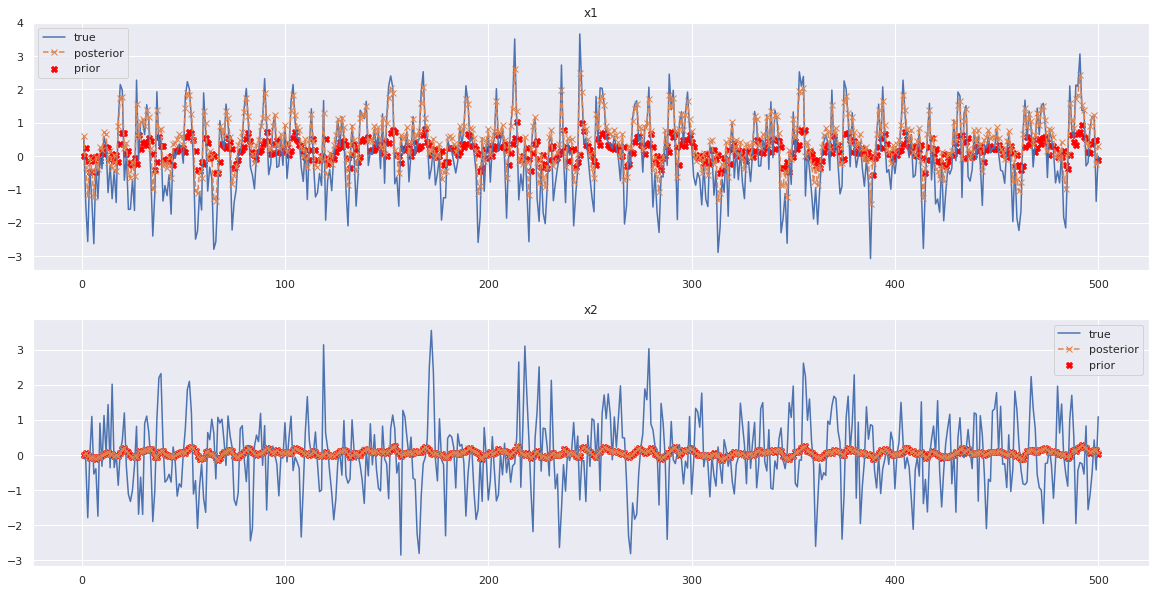

In [10]:
proc_results = proc_results(
    x_true=x_true,
    results=res
)